<a href="https://colab.research.google.com/github/gezmi/ColabDesign/blob/gamma/af/examples/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2_advanced_v2
aka. **Colab[Design]Fold**, we've come full circle...

WARNING: this is an experimental notebook. For anything serious please use our [colabfold](https://github.com/sokrypton/ColabFold) notebooks.

In [ ]:
%%time
#@title setup
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/gezmi/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap
from colabdesign.af import chains_ptms


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

In [ ]:
#@title prep_inputs
sequence = "PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK" #@param {type:"string"}
jobname = "test" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "none" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "A" #@param {type:"string"}
rm_template_seq = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
do_not_align = False #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
#@title pre_analysis (optional)
analysis = "coevolution" # @param ["none", "coevolution"]
dpi = 100 # @param ["100", "200", "300"] {type:"raw"}
if analysis == "coevolution":
  coevol = get_coevolution(msa)
  plt.figure(figsize=(5,5), dpi=dpi)
  plt.title("coevolution")
  plt.imshow(coevol)
  plt.axis(False)
  plt.show()

In [ ]:
#@title prep_model
#@markdown Model options
model_type = "auto" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
rank_by = "auto" #@param ["auto", "plddt", "ptm"]
debug = True #@param {type:"boolean"}
use_initial_guess = False

#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = True #@param {type:"boolean"}

#@markdown Extended metrics
extended_metrics = True #@param {type:"boolean"}

if extended_metrics:
  debug=True

if model_type == "monomer (ptm)":
  use_multimer = False
  pseudo_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
  pseudo_multimer = False
elif model_type == "pseudo_multimer (v3)":
  use_multimer = True
  pseudo_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
  pseudo_multimer = False
else:
  use_multimer = False
  pseudo_multimer = False

if rank_by == "auto":
  rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:

  # interchain masking determined by dgram
  af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence)
# set msa
af.set_msa(msa, deletion_matrix)

# set chainbreaks
L_prev = 0
for n,l in enumerate(u_sub_lengths * copies):
  for L_i in l[:-1]:
    af._inputs["residue_index"][L_prev+L_i:] += 32
    L_prev += L_i
  L_prev += l[-1]

# set cyclic constraints
i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
if len(i_cyclic) > 0:
  add_cyclic_offset(af,i_cyclic)

In [ ]:
%%time
#@title run_alphafold
#@markdown Model options
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 6 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = False #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = True #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = True #@param {type:"boolean"}

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          if extended_metrics:
            ifptm_pairwise, iptm_pairwise, per_chain_ptm = chains_ptms.get_pairwise_interface_metrics(af)
            info[-1].extend([iptm_pairwise, ifptm_pairwise, per_chain_ptm])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        if extended_metrics:
          ifptm_pairwise, iptm_pairwise, per_chain_ptm = chains_ptms.get_pairwise_interface_metrics(af)
          info[-1].extend([iptm_pairwise, ifptm_pairwise, per_chain_ptm])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
np.savez_compressed(f"{pdb_path}/best.npz",
                    plddt=aux_best["plddt"].astype(np.float16),
                    pae=aux_best["pae"].astype(np.float16),
                    tag=np.array(info[rank[0]][0]),
                    metrics=np.array(info[rank[0]][1]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    ifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
np.savez_compressed(f"{pdb_path}/all.npz",
                    plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                    pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                    tag=np.array([x[0] for x in info]),
                    metrics=np.array([x[1] for x in info]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    ifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

In [ ]:
#@title display_best_result (optional) {run: "auto"}
color = "pLDDT" #@param ["pLDDT","chain","rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [ ]:
#@title post_analysis (optional)

analysis = "animate_all_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

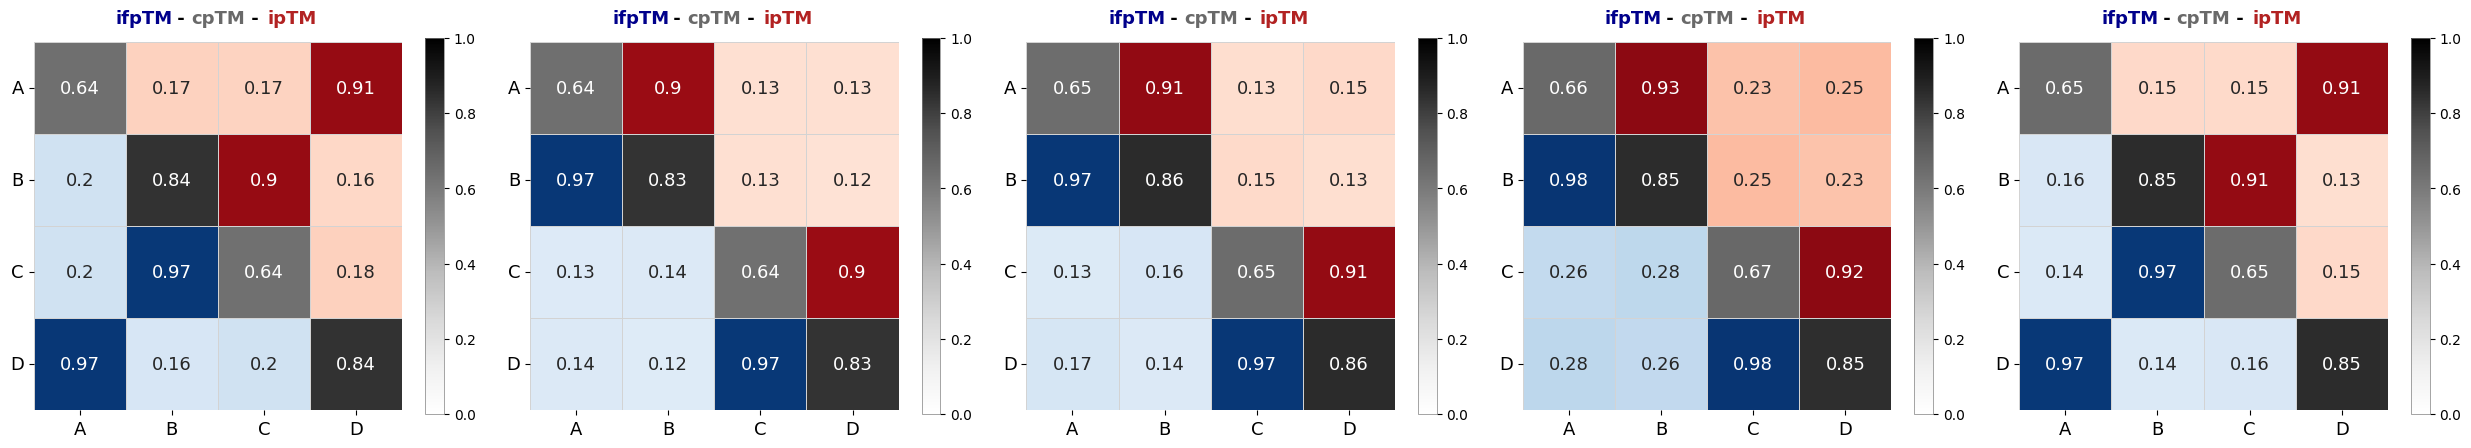

In [11]:
#@title Chain and pairwise analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_chain_pairwise_analysis(info):
    num_elements = len(info)
    fig, axes = plt.subplots(1, num_elements, figsize=(num_elements * 5, num_elements), squeeze=False)

    for idx, ax in enumerate(axes[0]):
        # get data from the info
        ifptm_dict = info[idx][4]
        iptm_dict = info[idx][3]
        cptm_dict = info[idx][5]

        # get chain id-s
        letters = sorted(set([key.split('-')[0] for key in ifptm_dict.keys()] + [key.split('-')[1] for key in ifptm_dict.keys()]))

        # initialize dataframe
        data = pd.DataFrame(np.zeros((len(letters), len(letters))), index=letters, columns=letters)

        # add the ifptm and iptm values to the dataframe
        for key, value in ifptm_dict.items():
            i, j = key.split('-')
            data.loc[j, i] = value
            data.loc[i, j] = iptm_dict[f'{i}-{j}']

        # add cptm cvalues to the dataframe
        for chain, value in cptm_dict.items():
            if chain in data.index:
                data.loc[chain, chain] = value

        # create masks for lower, upper triangles, and diagonal
        mask_upper = np.triu(np.ones(data.shape), k=1)
        mask_lower = np.tril(np.ones(data.shape), k=-1)
        mask_diagonal = np.eye(data.shape[0])

        figure_size = max(4, len(letters))

        # dynamically adjust the size, according to the number of chains
        dynamic_fontsize = 11 + (figure_size / 2)
        x_start = 0.3
        x_offset = 0.1

        annot_kws={'size': dynamic_fontsize}

        # lower triangle with blue colors
        sns.heatmap(data, mask=mask_upper + mask_diagonal, annot=True, cmap='Blues', cbar=False, edgecolor='grey',
                    linecolor='lightgrey', linewidths=0.5, vmax=1, vmin=0, square=True, ax=ax, annot_kws=annot_kws)

        # upper triangle with red colors
        sns.heatmap(data, mask=mask_lower + mask_diagonal, annot=True, cmap='Reds', cbar=False, edgecolor='grey',
                    linecolor='lightgrey', linewidths=0.5, vmax=1, vmin=0, square=True, ax=ax, annot_kws=annot_kws)

        # diagonal with greys
        diagonal_data = pd.DataFrame(np.diag(np.diag(data)), index=letters, columns=letters)
        heatmap = sns.heatmap(diagonal_data, mask=~mask_diagonal.astype(bool), annot=True, cmap='Greys', cbar=True, edgecolor='grey',
                    linecolor='lightgrey', linewidths=0.5, vmax=1, vmin=0, square=True, ax=ax, cbar_kws={'shrink': 0.8}, annot_kws=annot_kws)

        # format colorbar
        colorbar = heatmap.collections[2].colorbar
        colorbar.outline.set_edgecolor('grey')
        colorbar.outline.set_linewidth(0.5)

        # color the title, use it as a legend
        ax.text(x_start, 1.05, 'ifpTM', fontsize=dynamic_fontsize, fontweight='bold', color='darkblue', ha='center', transform=ax.transAxes)
        ax.text(x_start + x_offset, 1.05, ' - ', fontsize=dynamic_fontsize, fontweight='bold', color='black', ha='center', transform=ax.transAxes)
        ax.text(x_start + 2 * x_offset, 1.05, 'cpTM', fontsize=dynamic_fontsize, fontweight='bold', color='dimgrey', ha='center', transform=ax.transAxes)
        ax.text(x_start + 3 * x_offset, 1.05, ' - ', fontsize=dynamic_fontsize, fontweight='bold', color='black', ha='center', transform=ax.transAxes)
        ax.text(x_start + 4 * x_offset, 1.05, 'ipTM', fontsize=dynamic_fontsize, fontweight='bold', color='firebrick', ha='center', transform=ax.transAxes)

        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=dynamic_fontsize)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), size=dynamic_fontsize)

    plt.tight_layout()
    plt.savefig(f"{pdb_path}/chain_pairwise_ptm.png", dpi=200, bbox_inches='tight')
    plt.show()

plot_chain_pairwise_analysis(info)

In [ ]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

#FAQ
How is this notebook different from ColabFold?
- Assuming same settings, the results should be the same. The purpose of the notebook is to add more advanced options and give people more control on the python level.

How to specify chainbreaks?
- `sequence` Specify protein sequence to be modelled.
  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.

How to specify cyclic constraints?
- When entering sequence use `()` to specify which parts should be cyclic. For example: `ABC:(DEF):GHI`, the second protein will be cyclicalized.

**Extra options**
- `select_best_across_recycles` - select best model across all recycles.

I want to access all the raw outputs, how do I do this?
- Set: `debug`=`True`. After run_alphafold, you can access all outputs via `best_aux["debug"]["outputs"]`.

**Template options**

How to provide inter-chain templates?
- Set: template_mode=`custom`, pdb=`1abc`, chain=`A,B`
- for homo-oligomeric inputs set: `propagate_to_copies`=`False` otherwise same pdb will be copied to all.

For some reason the interchain template info is not used...
- Try `model_type`=`monomer` or `model_type`=`pseudo_multimer`.

How to provide more than one pdb, one for each sequence in the multimer?
- Set: template_mode=`custom`, pdb=`1abc:2abc`, chain=`A:A`

Can I use this notebook to simulate `af2rank`?
- `rm_template_seq` - removing the template sequence unlocks alpahfold's discriminatory power, see [af2rank](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.238101) for details.
- `use_mlm` (disabled in af2rank) enables random masking of input MSA.

**Currently not supported**
- Mixture of symmetries.
- Amber relax. To relax, use our [relax notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/relax_amber.ipynb).


